<a href="https://colab.research.google.com/github/bettytan123/Sample-Size-Calculation/blob/main/Hyperparameter_of_Binomal_Mean.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
############################################
## This script will simulate data from known statistical distributions; then estimate GAN and sample from it
##mar 3 3pm copy
## Authors: Betty and Chris, ft David
## Date: February 2023
############################################

In [2]:
############################################
## Installations of required modules not default available on COLAB compute software stack
############################################
! pip install sdv --quiet
! pip install --upgrade scipy --quiet
! pip install sinfo
! pip install torchinfo --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 KB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 KB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.6/63.6 KB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.7/140.7 KB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.0/47.0 KB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 26.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 KB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.2/280.2 KB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.2/15.2 MB 20.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.5/63.5 KB 5.2 MB/s eta 0:00:00
  Created wheel for sinfo: filename=sinfo-0.3.4-py3-none-

In [135]:
########################
## Import dependency packages
########################

## Import SDV for GANs and sampling mechanisms, etc.
from sdv.tabular import CTGAN

## Import pandas for data structures
import pandas as pd

## Import numpy for numerical computing
import numpy as np

## Import scipy for statistical distirbution function 
import scipy

## For plotting
import matplotlib.pyplot as plt

## For timing
from time import time

## Random Numbers
import random

# For progress bars
from tqdm.notebook import tqdm, trange

# Do not display warnings (bad practice)
import warnings
warnings.filterwarnings("ignore")

# For CUDA enabled/accelerated computation on the GPU 
import torch

import matplotlib.pyplot as plt
import seaborn as sns

from io import StringIO

from torchinfo import summary

sns.set_style('darkgrid')

In [4]:
# model = CTGAN(epochs=3)
# model.fit(pd.DataFrame({'x': np.random.random(size=(10))}))
# summary(model)

In [5]:
## Set seed of everything, the best will be to set them once and run all the notebook
np.random.seed(614)
torch.manual_seed(614)
random.seed(614)
scipy.stats.rv_continuous.random_state = 614

In [6]:
#####################################
##
## Sample Size for Precision of a Continuous Normal Random Variable --- by Mathematical Theory
##
#####################################

In [7]:
scipy.stats.norm.ppf(q=0.025, loc=0, scale=1)

-1.9599639845400545

In [8]:
## Sample size by math
def samp_size_bin_ci(alpha, proportion, width):
    n = (4 * (scipy.stats.norm.ppf(q=alpha/2, loc=0, scale=1)**2) * proportion*(1-proportion) / (width**2))
    return n

In [9]:
samp_size_bin_ci(alpha=0.05, proportion=0.2, width=0.1) ##245.8534

245.8533645244241

In [10]:
#################################
##
## Sample Size for Precision of a Continuous Normal Random Variable --- by numerical simulation
##
################################

In [11]:
def bin_ci_samp_size(n, p, size):
    ## Generate random data
    x = np.random.binomial(n= 1, p = 0.2, size = 245)
    ## Analyze generated/simulated data
    k = np.sum(x)
    n = len(x)
    res = scipy.stats.binomtest(k=k, n =n, p=p, alternative='two-sided')

    ## Extract the estimate and CI
    mu_ll, mu_ul = res.proportion_ci(confidence_level=0.95)
    mu_hat = np.mean(x)
    
    # Return the estimate and the CI to the user
    # [] make it a list instead of scalar
    out = pd.DataFrame({'mean': [mu_hat],
                        'll95_mean': [mu_ll],
                        'ul95_mean': [mu_ul]})
    
    return(out)

In [12]:
bin_ci_samp_size(n=1, p=0.2, size=245)

mean  ll95_mean  ul95_mean
0  0.216327   0.166444   0.273213

In [13]:
## Replicate above function number of simulation replicate times

# parameter available  
n = int(np.ceil(samp_size_bin_ci(alpha=0.05, proportion=0.2, width=0.1)))
p = 0.2


## Number simulation replicates
n_rep = 10000

## Simulate n_rep copies of sample size trials
sim_out = []

## Loop over number simulation replicates, storing results in list
t0 = time()

for i in trange(0, n_rep):
    sim_out.append(bin_ci_samp_size(n=1, p=p, size=n))

t1 = time()
runtime = t1 - t0

### Aggregate results into dataframe
sim_df = pd.concat(sim_out)

#Calculate means of each column in the array #axis means column mean 
sim_means = np.mean(sim_df, axis=0)

#Calculate the width of the confidence interval
ci_width = sim_means[2] - sim_means[1]

  0%|          | 0/10000 [00:00<?, ?it/s]

In [14]:
## Collect the sample size simulation results into a single dataFrame
sim_results = pd.DataFrame({
    'runtime': [runtime],
    'mean_hat': [sim_means[0]],
    'mean_ll95': [sim_means[1]],
    'mean_ul95': [sim_means[2]],
    'ci_width': [ci_width]
})

sim_results

runtime  mean_hat  mean_ll95  mean_ul95  ci_width
0  106.974505  0.200175   0.152092   0.255673  0.103581

In [17]:
#############################################################
##
## Sample size estimation by GAN simulation
##
#############################################################

In [18]:
## Function to train a GAN model to simulated binormal data (with parms: p, size)
def train_gan_model_binormal(pop_n, pop_p, pop_size):
    ## Set seed of everything, ONLY FOR THE GAN 
    np.random.seed(614)
    torch.manual_seed(614)
    random.seed(614)
    scipy.stats.rv_continuous.random_state = 614

    ## Simulate data as input to GAN
    x = np.random.binomial(n= pop_n, p = pop_p, size = pop_size)
    
    #   ## Convert vector to pandas dataFrame
    x_pd = pd.DataFrame({"x": x})

    ## Feed the simulated data into SDV and sample synthetic data from the fitted GAN
    model = CTGAN(
        embedding_dim = 200, 
        generator_dim = (2,2), 
        discriminator_dim = (2,2),
        generator_lr = 0.01, 
        discriminator_lr = 0.01, 
        batch_size = 1000, 
        verbose=True, 
        epochs=4000,
        generator_decay = 0.01, 
        discriminator_decay = 0.01
    )

    ## Fit a GAN to the simulated data from above
    model.fit(x_pd)
    
    ## Return the learned model
    out = [model, x_pd]

    return out

In [19]:
# %%time
%%capture output

## Parameters of binormal parent distribution
p=0.2
n = 10000

## Get the learned GAN model --- after training 
t0 = time()
train_gan = train_gan_model_binormal(pop_n=1, pop_p=p, pop_size=n)
t1 = time()
fit_time = t1 - t0
fit_time

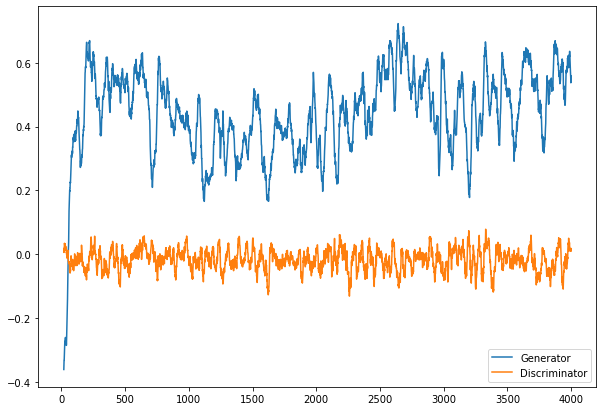

In [53]:
logs = StringIO(str(output))
window = 10 # window size for the moving average, window=1 gets you the original series

df = pd.read_csv(logs, sep=",", names=['Epochs', 'Loss G', 'Loss D'])

# I think a regex would be better here
df['Loss G'] = df['Loss G'].apply(lambda x: float(x.split(':')[1]))
df['Loss D'] = df['Loss D'].apply(lambda x: float(x.split(':')[1]))

plt.figure(figsize=(10,7))

# Plot with a moving average so it is less noisy
plt.plot(df['Loss G'].rolling(window=window).mean(), label="Generator")
plt.plot(df['Loss D'].rolling(window=window).mean(), label="Discriminator")

plt.legend()
plt.show()

In [21]:
model_ = train_gan[0]

In [22]:
## Summarize moments of the "parent distribution" used to simulate the synthetic GAN data
x_parent = train_gan[1]

x_parent.describe()

x
count  10000.000000
mean       0.201000
std        0.400768
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000

In [23]:
## Parameter for specifying size of the simulated/synthetic data generated from the GAN
sim_n = int(np.ceil(samp_size_bin_ci(alpha=0.05, proportion=0.2, width=0.1)))
sim_n

246

In [24]:
## Function to analyze data from the sampled model 
def binorm_ci_samp_size_gan(m, sim_n):
    ## Generate random data --- sampling from the trained GAN which approximates the normal probability generating function
    x = m.sample(num_rows=sim_n)
    ## Analyze generated/simulated data
    #k = np.sum(x).round(0).astype('int')
    k = np.sum(x)
    k = int(k)
    n = len(x)
    p = 0.2
    res = scipy.stats.binomtest(k=k, n =n, p=p, alternative='two-sided')

    ## Extract the estimate and CI
    mu_ll, mu_ul = res.proportion_ci(confidence_level=0.95)
    mu_hat = np.mean(x)
   
    # Return the estimate and the CI to the user
    out = pd.DataFrame({'mean': [mu_hat],
                         'll95_mean': [mu_ll],
                         'ul95_mean': [mu_ul]})
    return(out)

In [25]:
## Replicate above function number of simulation replicate times

## Number simulation replicates
n_rep = 1000

## Simulate n_rep copies of sample size trials
gan_out = []

## Loop over number simulation replicates, storing results in list
t0 = time()

for i in trange(0, n_rep):
    gan_out.append(binorm_ci_samp_size_gan(m=model_, sim_n=sim_n))

t1 = time()
runtime = t1 - t0

## Aggregate results into dataframe
gan_df = pd.concat(gan_out)

## Calculate means of each column in the array #axis means column mean 
gan_means = np.mean(gan_df, axis=0)

## Calculate the width of the confidence interval
gan_width = gan_means[2] - gan_means[1]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [26]:
## Collect results of the GAN based sample size calculations
gan_results = pd.DataFrame({
    'runtime': [runtime],
    'mean_hat': [gan_means[0]],
    'mean_ll95': [gan_means[1]],
    'mean_ul95': [gan_means[2]],
    'ci_width': [gan_width]
})

gan_results

runtime  mean_hat  mean_ll95  mean_ul95  ci_width
0  24.984515  0.087634   0.055667   0.129967  0.074299

In [27]:
#########################################################################
##
##
## Below we investgiate finite sample properties of three methods for estimating sample size for a continuous CI from normal distribution
##    1) Theory or analytic formula
##    2) Simulation (from normal probability generating model)
##    3) Simulation (from GAN approximating parent normal probability generating model)
##
##
#########################################################################

In [28]:
###########################
## Create parameter grid
###########################
from itertools import product

def expand_grid(dictionary):
   return pd.DataFrame([row for row in product(*dictionary.values())], columns=dictionary.keys())

dictionary = {'alpha': [0.05], 
              'p': np.arange(0.1, 0.5, 0.1), 
              'width': [0.05,0.1,0.15,0.20,0.25]}

param_df = expand_grid(dictionary)
param_df

alpha    p  width
0    0.05  0.1   0.05
1    0.05  0.1   0.10
2    0.05  0.1   0.15
3    0.05  0.1   0.20
4    0.05  0.1   0.25
5    0.05  0.2   0.05
6    0.05  0.2   0.10
7    0.05  0.2   0.15
8    0.05  0.2   0.20
9    0.05  0.2   0.25
10   0.05  0.3   0.05
11   0.05  0.3   0.10
12   0.05  0.3   0.15
13   0.05  0.3   0.20
14   0.05  0.3   0.25
15   0.05  0.4   0.05
16   0.05  0.4   0.10
17   0.05  0.4   0.15
18   0.05  0.4   0.20
19   0.05  0.4   0.25

In [29]:
#################
## 1) Sample Size for Continuous CI by Theory or Analytic Formula
#################
samp_size_theory_list = []

for i in np.arange(param_df.shape[0]):
    ## Compute sample size at particular parameter condiguration
    n = samp_size_bin_ci(alpha=param_df.loc[i, 'alpha'], 
                          proportion=param_df.loc[i, 'p'],
                          width=param_df.loc[i, 'width'])
    ## Round to largest integer
    n_ = str(np.round(np.ceil(n),0))
    ## Append sample size to list
    samp_size_theory_list.append(n_)

samp_size_theory_df = pd.concat([param_df, pd.Series(samp_size_theory_list)], axis=1)
samp_size_theory_df.columns = ['alpha','p','width','n_theory']
samp_size_theory_df

alpha    p  width n_theory
0    0.05  0.1   0.05    554.0
1    0.05  0.1   0.10    139.0
2    0.05  0.1   0.15     62.0
3    0.05  0.1   0.20     35.0
4    0.05  0.1   0.25     23.0
5    0.05  0.2   0.05    984.0
6    0.05  0.2   0.10    246.0
7    0.05  0.2   0.15    110.0
8    0.05  0.2   0.20     62.0
9    0.05  0.2   0.25     40.0
10   0.05  0.3   0.05   1291.0
11   0.05  0.3   0.10    323.0
12   0.05  0.3   0.15    144.0
13   0.05  0.3   0.20     81.0
14   0.05  0.3   0.25     52.0
15   0.05  0.4   0.05   1476.0
16   0.05  0.4   0.10    369.0
17   0.05  0.4   0.15    164.0
18   0.05  0.4   0.20     93.0
19   0.05  0.4   0.25     60.0

In [30]:
########################
## 2) Sample Size for Continuous CI by Simulation from binormal Distribution
########################

In [31]:
def binorm_ci_samp_size(n, p, size):    
    ## Generate random data
    x = np.random.binomial(n= 1, p = p, size = size)
    ## Analyze generated/simulated data
    k = np.sum(x)
    n = len(x)
    res = scipy.stats.binomtest(k=k, n =n, p=p, alternative='two-sided')

    ## Extract the estimate and CI
    mu_ll, mu_ul = res.proportion_ci(confidence_level=0.95)
    mu_hat = np.mean(x)
    
    # Return the estimate and the CI to the user
    # [] make it a list instead of scalar
    out = pd.DataFrame({'mean': [mu_hat],
                        'll95_mean': [mu_ll],
                        'ul95_mean': [mu_ul]})
    
    return(out)


In [32]:
binorm_ci_samp_size(n=1, p=0.2, size=245)

mean  ll95_mean  ul95_mean
0  0.171429   0.126432   0.224573

In [33]:
##
## Replicate above function to compute expected CI width, for continuous mean, at various parm values (mu, std, n) over number sim replicated (n_rep)
##
def binorm_ci_samp_size_sim( p, size, n_rep):

    ## Simulate n_rep copies of sample size trials
    sim_out = []

    ## Loop over number simulation replicates, storing results in list
    t0 = time()

    for i in trange(0, n_rep):
        sim_out.append(binorm_ci_samp_size(n=1, p=p, size=size))

    t1 = time()
    runtime = t1 - t0

    ### Aggregate results into dataframe
    sim_df = pd.concat(sim_out)

    ## Calculate means of each column in the array 
    sim_means = np.mean(sim_df, axis=0)

    ## Calculate the width of the confidence interval
    ci_width = sim_means[2] - sim_means[1]

    ## Return expect width 
    return ci_width

In [34]:
binorm_ci_samp_size_sim( p=0.2, size=245, n_rep=100)

  0%|          | 0/100 [00:00<?, ?it/s]

0.10326617463483848

In [35]:
## Loop over theoretical table, to use simulation to understand relationship between (n, p, size, n_rep) etc.
samp_size_sim_list = []

## 1000 simulation replicates; reduces computational burden
n_rep = 10000

t0 = time()

for i in np.arange(samp_size_theory_df.shape[0]):
    ## Compute sample size at particular parameter condiguration
    ci_width = binorm_ci_samp_size_sim(size=int(float(samp_size_theory_df.loc[i, 'n_theory'])), 
                          p=samp_size_theory_df.loc[i, 'p'],
                          n_rep=n_rep)
    ## Round to largest integer
    ci_width_ = str(np.round(ci_width,4))
    ## Append sample size to list
    samp_size_sim_list.append(ci_width_)

t1 = time()
sim_time = t1-t0

## Compile results into dataFrame
samp_size_sim_df = pd.concat([samp_size_theory_df, pd.Series(samp_size_sim_list)], axis=1)
samp_size_sim_df.columns = ['alpha','p','width','n_theory','ci_width_sim']
samp_size_sim_df

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

alpha    p  width n_theory ci_width_sim
0    0.05  0.1   0.05    554.0       0.0516
1    0.05  0.1   0.10    139.0       0.1058
2    0.05  0.1   0.15     62.0       0.1616
3    0.05  0.1   0.20     35.0       0.2167
4    0.05  0.1   0.25     23.0       0.2712
5    0.05  0.2   0.05    984.0       0.0509
6    0.05  0.2   0.10    246.0       0.1033
7    0.05  0.2   0.15    110.0       0.1565
8    0.05  0.2   0.20     62.0       0.2092
9    0.05  0.2   0.25     40.0       0.2617
10   0.05  0.3   0.05   1291.0       0.0507
11   0.05  0.3   0.10    323.0       0.1025
12   0.05  0.3   0.15    144.0       0.1548
13   0.05  0.3   0.20     81.0       0.2075
14   0.05  0.3   0.25     52.0       0.2594
15   0.05  0.4   0.05   1476.0       0.0506
16   0.05  0.4   0.10    369.0       0.1022
17   0.05  0.4   0.15    164.0       0.1544
18   0.05  0.4   0.20     93.0       0.2059
19   0.05  0.4   0.25     60.0       0.2569

In [36]:
## Timing for the simulation experiments
sim_time

1784.3825542926788

In [42]:
########################
## 3) Sample Size for Continuous CI by Generative Adversarial Network (GAN) from a (parent) Normal Distribution
########################

In [43]:
## Function to train a GAN model to simulated normal data (with parms: mean, sd, n)
def train_gan_model_binormal(pop_p, pop_size):
    ## Set seed of everything
    np.random.seed(614)
    torch.manual_seed(614)
    random.seed(614)
    scipy.stats.rv_continuous.random_state = 614

    ## Simulate data as input to GAN
    x = np.random.binomial(n=1, p=pop_p, size=pop_size)

    #   ## Convert vector to pandas dataFrame
    x_pd = pd.DataFrame({"x": x})

    ## Feed the simulated data into SDV and sample synthetic data from the fitted GAN
    model = CTGAN(embedding_dim = 200, 
                  generator_dim = (2,2), 
                  discriminator_dim = (2,2),
                  generator_lr = 0.01, 
                  discriminator_lr = 0.01, 
                  batch_size = 1000, 
                  verbose=False, 
                  epochs=4000,
                  generator_decay = 0.01, 
                  discriminator_decay = 0.01
                  )

    ## Fit a GAN to the simulated data from above
    model.fit(x_pd)
    
    ## Return the learned model
    out = [model, x_pd]

    return out

## hyperparmeter trying 1

In [75]:
from sklearn.model_selection import ParameterGrid
random.seed(614)

hparams = {
    'generator_lr': [0.0001, 0.001, 0.01, 0.1],                # TODO: add distribution here
    'discriminator_lr': [0.0001, 0.001, 0.01, 0.1],            # TODO: add distribution here
    'embedding_dim': [128, 256, 512],
    'generator_dim': [(128, 128), (256, 256), (512, 512)],
    'discriminator_dim': [(128, 128), (256, 256), (512, 512)],
    'discriminator_steps': [1, 5]
}

parameter_grid = list(ParameterGrid(hparams))
parameter_grid = random.sample(parameter_grid, 20)
parameter_grid[0]

{'discriminator_dim': (128, 128),
 'discriminator_lr': 0.1,
 'discriminator_steps': 5,
 'embedding_dim': 128,
 'generator_dim': (256, 256),
 'generator_lr': 0.1}

In [76]:
import sys
 
path = 'logs.txt'
sys.stdout = open(path, 'w')

In [77]:
## Function to train a GAN model to simulated normal data (with parms: mean, sd, n)
def train_gan_model_binormal_hparams(hparams):
    pop_p = 0.2
    pop_size = 246
    
    ## Set seed of everything
    np.random.seed(614)
    torch.manual_seed(614)
    random.seed(614)
    scipy.stats.rv_continuous.random_state = 614

    ## Simulate data as input to GAN
    x = np.random.binomial(n=1, p=pop_p, size=pop_size)

    #   ## Convert vector to pandas dataFrame
    x_pd = pd.DataFrame({"x": x})

    ## Feed the simulated data into SDV and sample synthetic data from the fitted GAN
    model = CTGAN( 
        verbose=True, 
        epochs=4000,
        **hparams
      )

    ## Fit a GAN to the simulated data from above
    model.fit(x_pd)
    
    ## Return the learned model
    out = [model, x_pd]

    return out

In [78]:
# %%time
# %%capture output

## Parameters of binormal parent distribution
p=0.2
n = 10000

for hparam in tqdm(parameter_grid):
    print(f'hparam: {hparam}')
    train_gan_model_binormal_hparams(hparam)

  0%|          | 0/20 [00:00<?, ?it/s]

In [79]:
with open('logs.txt') as file:
    lines = file.readlines()

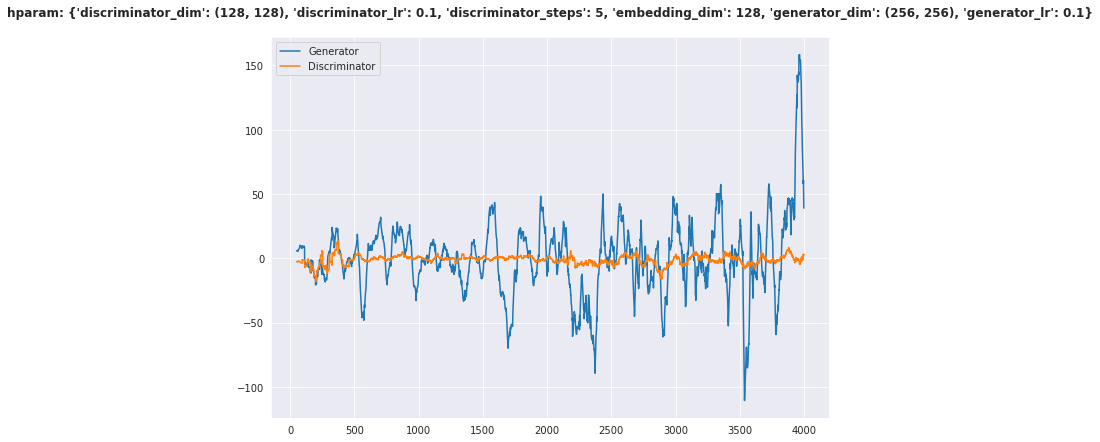

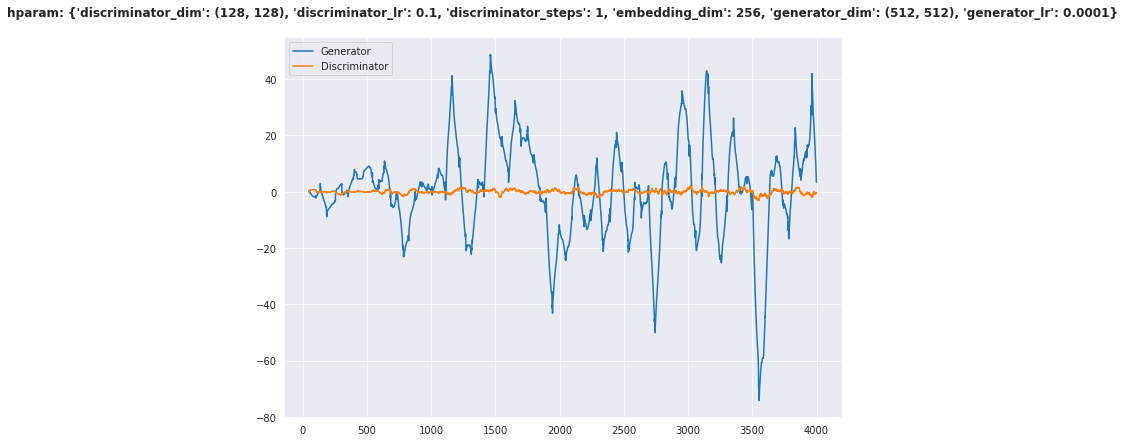

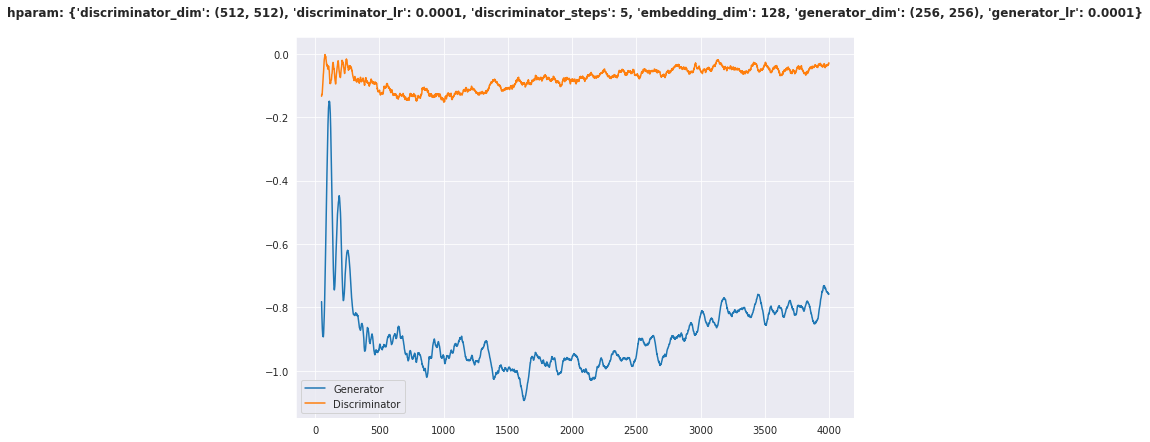

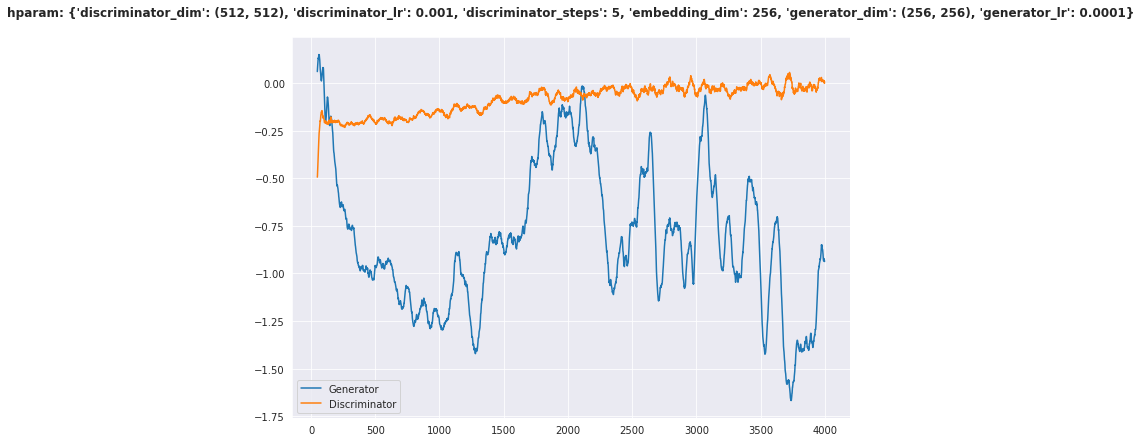

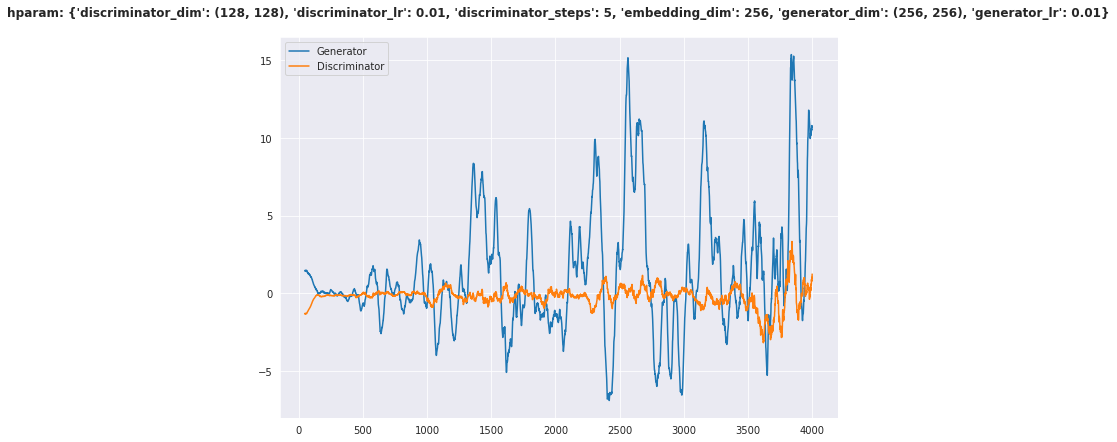

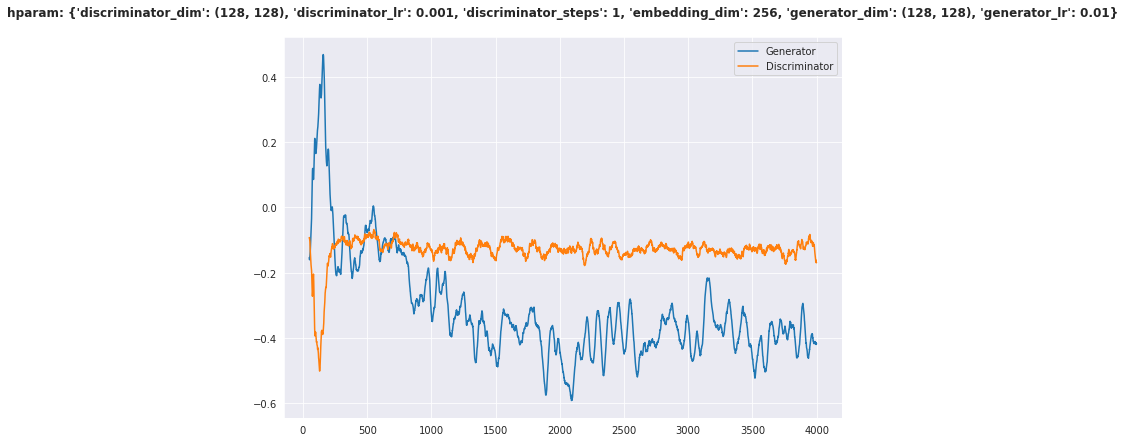

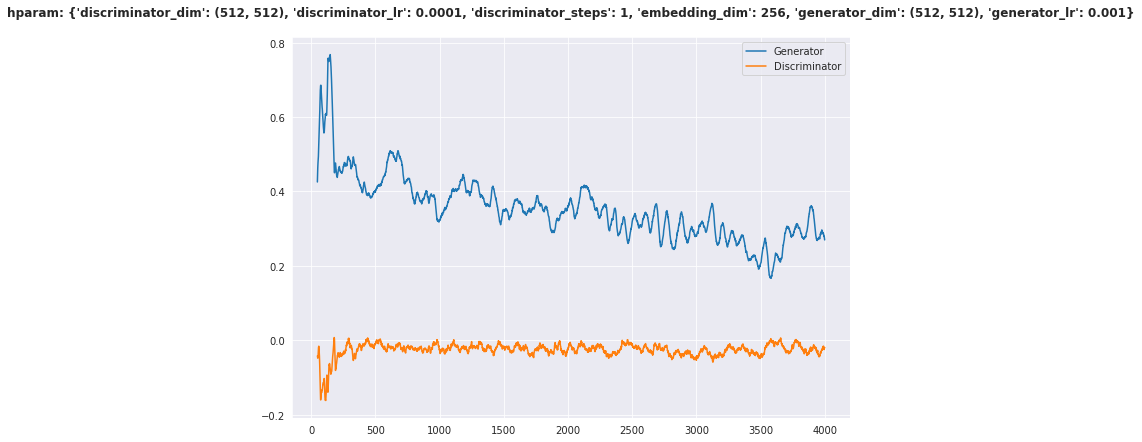

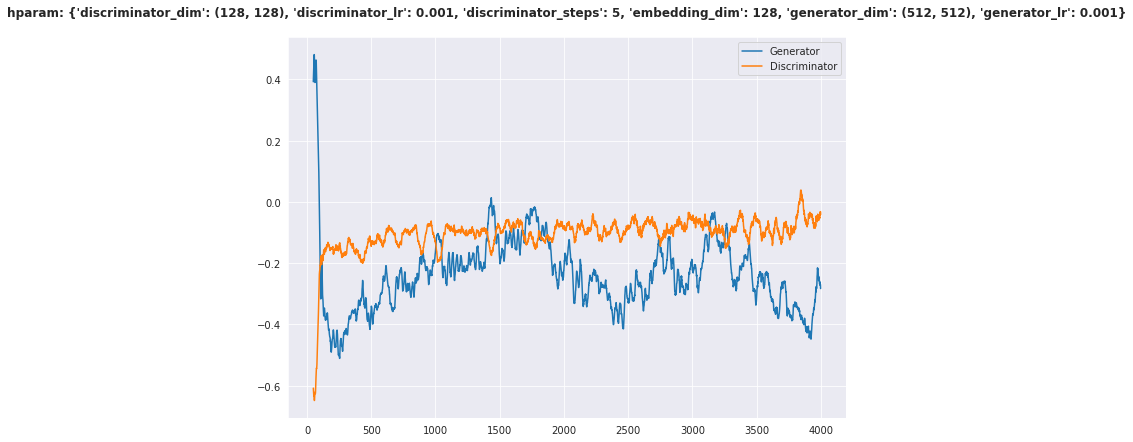

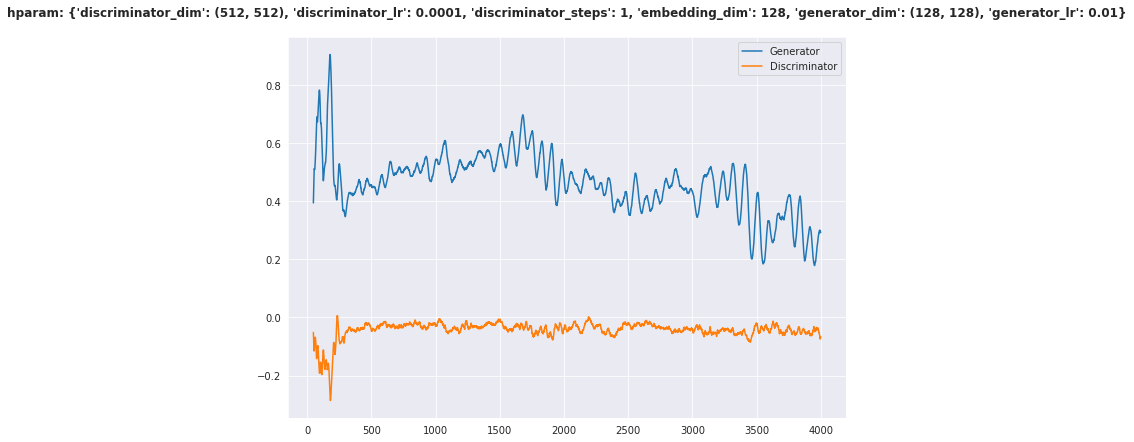

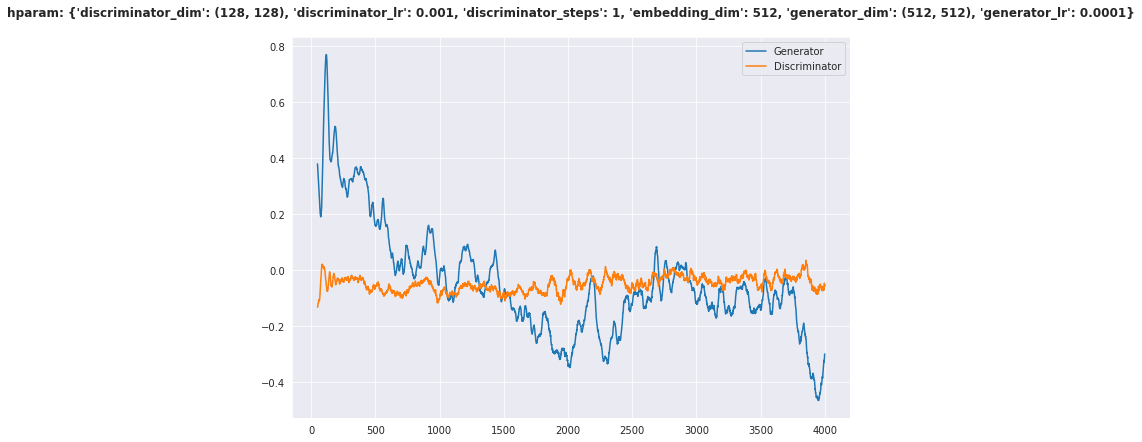

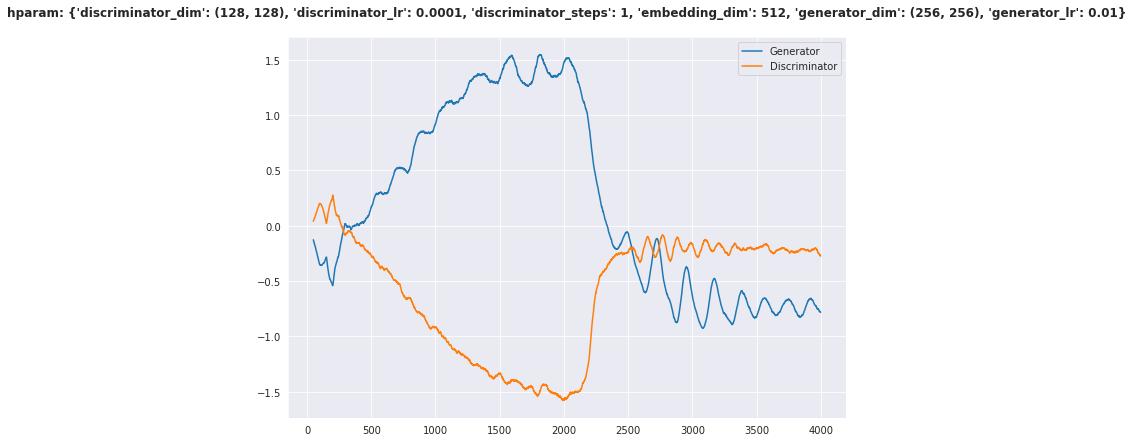

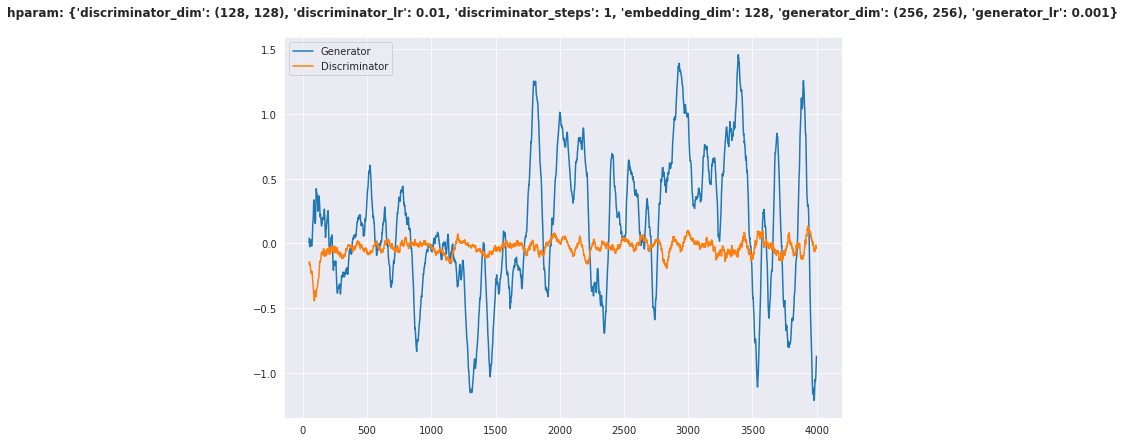

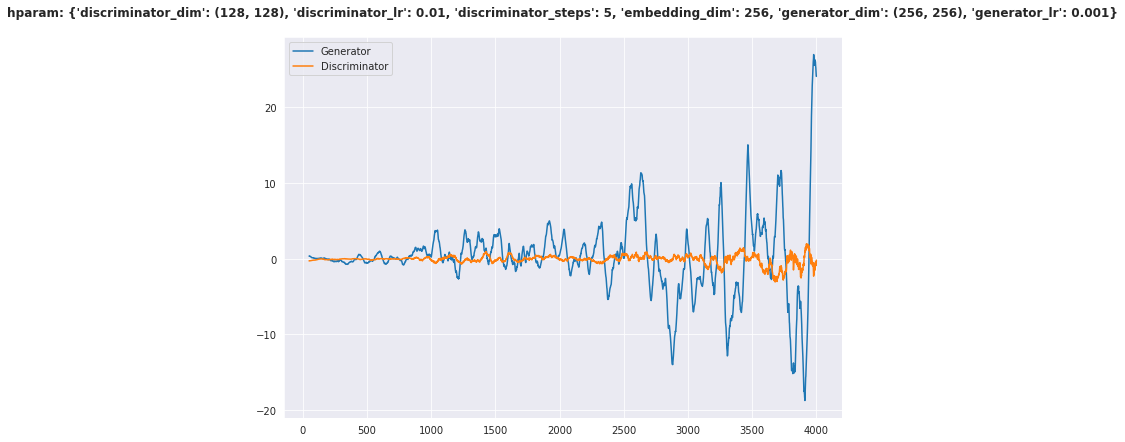

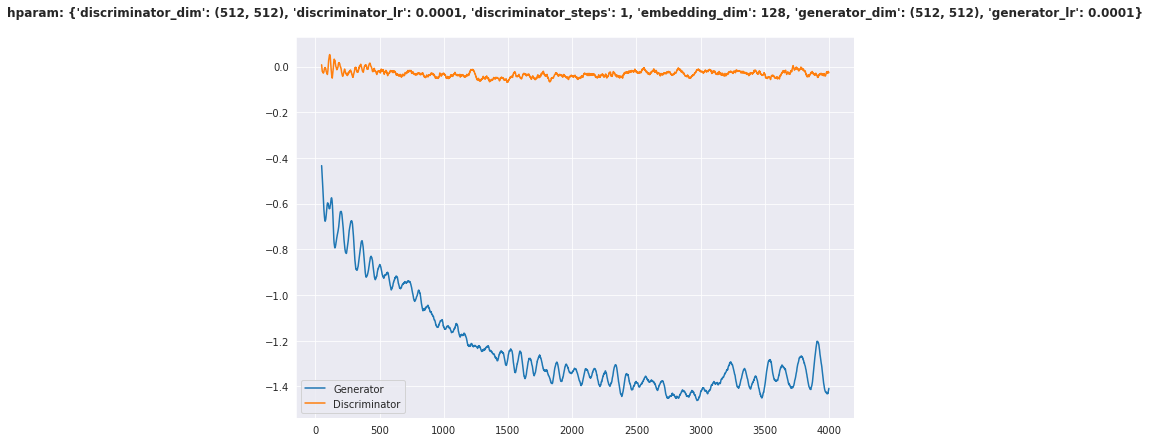

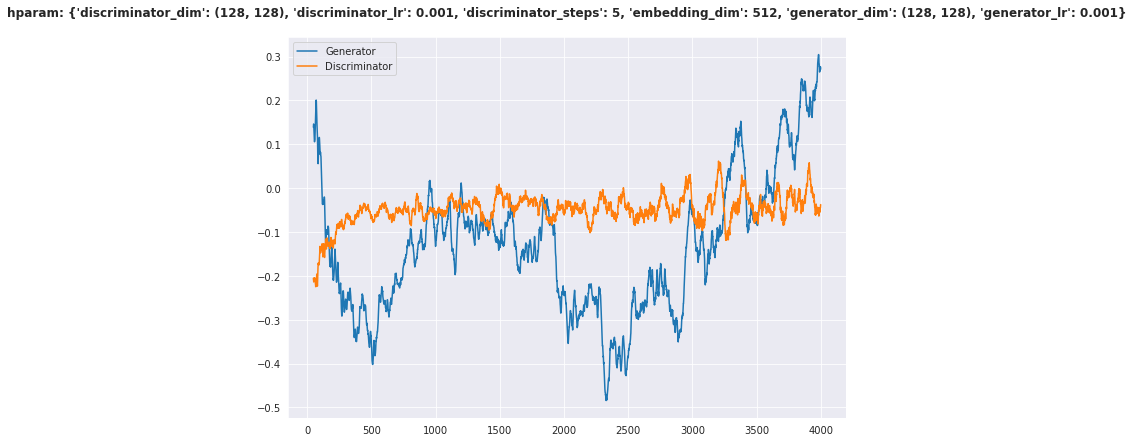

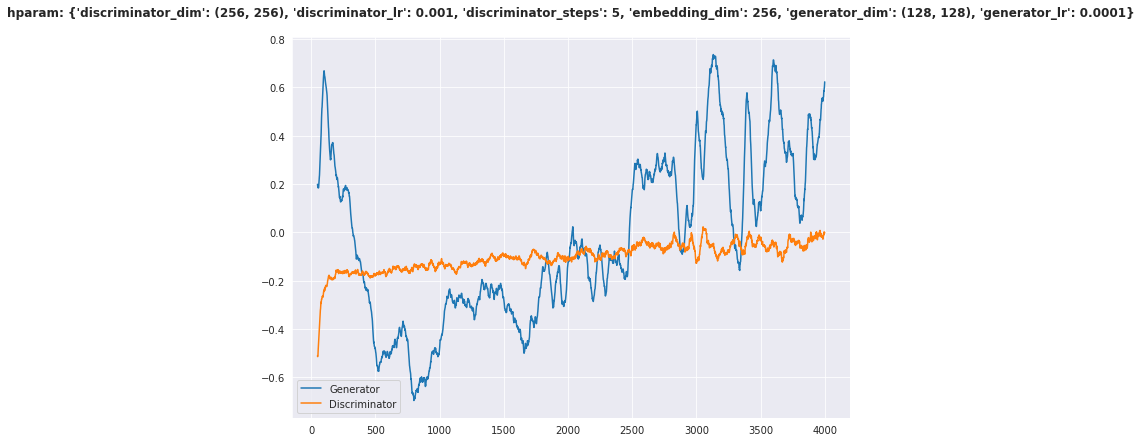

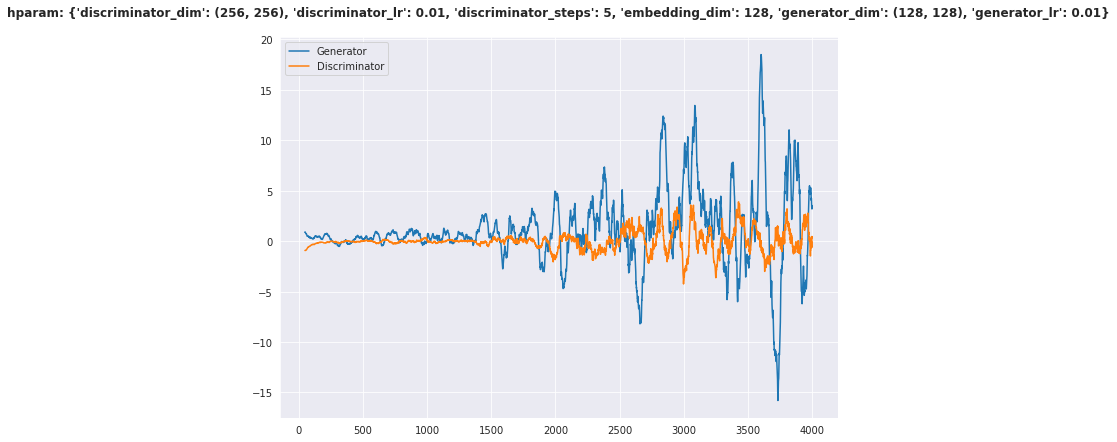

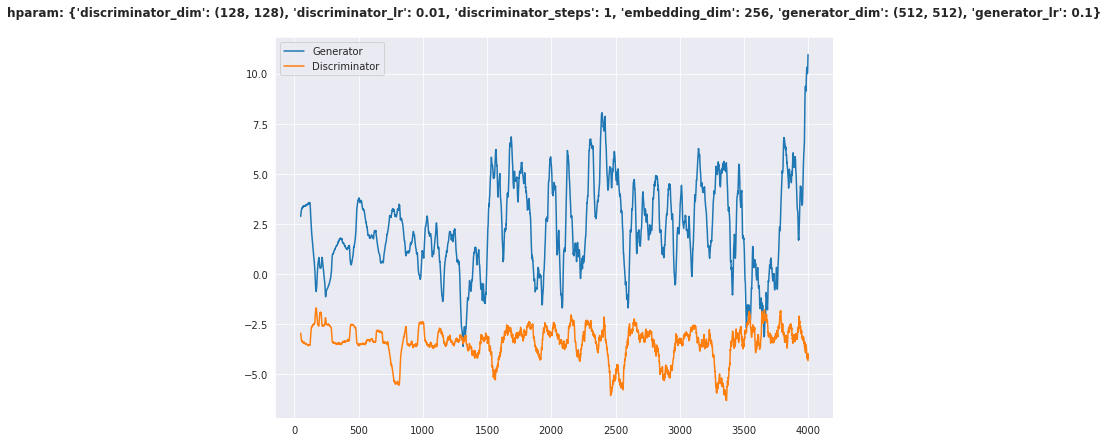

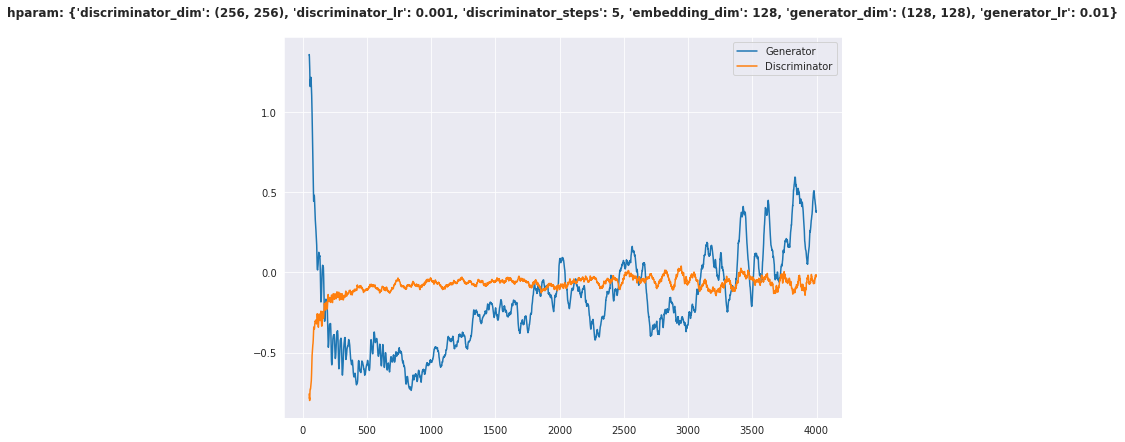

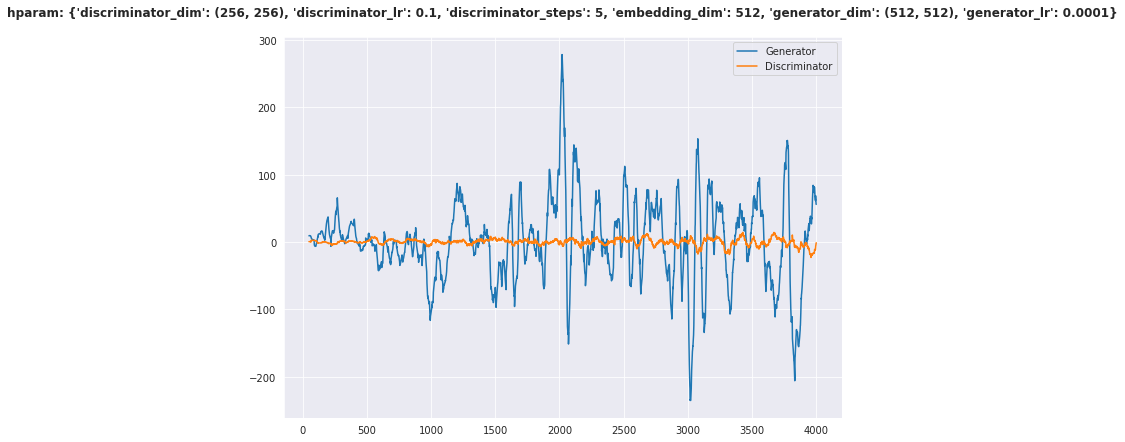

In [138]:
n = 4001
for i in range(0, len(lines), n):
    hparam_logs = lines[i: i + n]

    name = str(hparam_logs[0])
    output = "".join(hparam_logs[1:])

    output = StringIO(str(output))
    window = 50

    df = pd.read_csv(output, sep=",", names=['Epochs', 'Loss G', 'Loss D'])

    # I think a regex would be better here
    df['Loss G'] = df['Loss G'].apply(lambda x: float(x.split(':')[1]))
    df['Loss D'] = df['Loss D'].apply(lambda x: float(x.split(':')[1]))

    plt.figure(figsize=(10,7))

    # Plot with a moving average so it is less noisy
    plt.plot(df['Loss G'].rolling(window=window).mean(), label="Generator")
    plt.plot(df['Loss D'].rolling(window=window).mean(), label="Discriminator")

    plt.title(name, weight='bold')
    plt.legend()
    plt.show()

In [44]:
##
## Replicate above function to compute expected CI width, for continuous mean, at various parm values (mu, std, n) over number sim replicated (n_rep)
##
def binorm_ci_samp_size_gan(pop_p, pop_size, n_rep):

    ## Get the learned GAN model --- after training 
    t0 = time()
    train_gan = train_gan_model_binormal(pop_p=pop_p, pop_size=pop_size)
    t1 = time()
    fit_time = t1 - t0
    #fit_time
    
    ## Extract learned GAN model
    model_ = train_gan[0]

    ## Function to analyze data from the sampled model 
    def binorm_ci_samp_size_gan(m, pop_size):
        ## Generate random data --- sampling from the trained GAN which approximates the normal probability generating function
        x = m.sample(num_rows=pop_size)
        ## Analyze generated/simulated data
        k = np.sum(x)
        k = int(k)
        n = len(x)
        res = scipy.stats.binomtest(k=k, n =n, p=p, alternative='two-sided')
    
        ## Extract the estimate and CI
        mu_ll, mu_ul = res.proportion_ci(confidence_level=0.95)
        mu_hat = np.mean(x)
 
        # Return the estimate and the CI to the user
        out = pd.DataFrame({'mean': [mu_hat],
                         'll95_mean': [mu_ll],
                         'ul95_mean': [mu_ul]})
        return(out)
    
    ##
    ## Replicate above function number of simulation replicate times
    ##

    ## Simulate n_rep copies of sample size trials
    gan_out = []
 
    ## Loop over number simulation replicates, storing results in list
    t0 = time()

    for i in trange(0, n_rep):
        gan_out.append(binorm_ci_samp_size_gan(m=model_, pop_size=pop_size))

    t1 = time()
    gan_time = t1 - t0

    ## Aggregate results into dataframe
    gan_df = pd.concat(gan_out)

    ## Calculate means of each column in the array #axis means column mean 
    gan_means = np.mean(gan_df, axis=0)

    ## Calculate the width of the confidence interval
    gan_width = gan_means[2] - gan_means[1]

    ## Return the GAN estimated CI width
    return gan_width

In [45]:
##
## WARNING...notice very subtle difference between pop_n and sim_n
##
## "sim_n" should be set to size of theoretical sample size needed to obtain CI of expected width, given SD/alpha/mean
##
## "pop_n" can vary...larger values mean GAN parent dist is more likely converge in dist to population model, smaller values reduce likelihood convergence in dist
##     --- larger values can also substantially increase training time for the GAN model
##

t0 = time()

tmp = binorm_ci_samp_size_gan(pop_p=0.2, pop_size=int(np.ceil(samp_size_bin_ci(alpha=0.05, proportion=0.2, width=0.1))), 
                              n_rep=1000)

t1 = time()

[tmp, t1-t0]

Epoch 1, Loss G: -0.7428,Loss D: -0.0282
Epoch 2, Loss G: -0.7263,Loss D: -0.0006
Epoch 3, Loss G: -0.6735,Loss D: -0.0231
Epoch 4, Loss G: -0.6474,Loss D:  0.0475
Epoch 5, Loss G: -0.5798,Loss D:  0.1669
Epoch 6, Loss G: -0.5855,Loss D: -0.0563
Epoch 7, Loss G: -0.5820,Loss D:  0.0374
Epoch 8, Loss G: -0.6077,Loss D:  0.0550
Epoch 9, Loss G: -0.5836,Loss D:  0.1324
Epoch 10, Loss G: -0.5496,Loss D:  0.1868
Epoch 11, Loss G: -0.5954,Loss D:  0.0471
Epoch 12, Loss G: -0.5543,Loss D:  0.0673
Epoch 13, Loss G: -0.5108,Loss D:  0.0870
Epoch 14, Loss G: -0.4690,Loss D:  0.2186
Epoch 15, Loss G: -0.4399,Loss D: -0.0254
Epoch 16, Loss G: -0.5015,Loss D:  0.0465
Epoch 17, Loss G: -0.4232,Loss D: -0.0506
Epoch 18, Loss G: -0.4648,Loss D:  0.0852
Epoch 19, Loss G: -0.4559,Loss D:  0.0346
Epoch 20, Loss G: -0.4358,Loss D:  0.0087
Epoch 21, Loss G: -0.4000,Loss D:  0.2051
Epoch 22, Loss G: -0.3404,Loss D:  0.0818
Epoch 23, Loss G: -0.5163,Loss D:  0.2181
Epoch 24, Loss G: -0.3178,Loss D:  0.1449
E

  0%|          | 0/1000 [00:00<?, ?it/s]

[0.09677280674969944, 96.0762848854065]

In [46]:
## Loop over theoretical table, to use simulation to understand relationship between (n, mu, std, n_rep) etc.
samp_size_gan_list = []

## 1000 simulation replicates; reduces computational burden
n_rep = 1000

t0 = time()

for i in np.arange(samp_size_theory_df.shape[0]):
    ## Compute sample size at particular parameter condiguration
    ci_width = binorm_ci_samp_size_gan(
                      pop_p=samp_size_theory_df.loc[i, 'p'], 
                      pop_size=int(float(samp_size_theory_df.loc[i, 'n_theory'])),
                      n_rep=n_rep)
    ## Round to largest integer
    ci_width_ = str(np.round(ci_width,4))
    ## Append sample size to list
    samp_size_gan_list.append(ci_width_)

t1 = time()
gan_time = t1-t0

## Compile results into dataFrame
samp_size_gan_df = pd.concat([samp_size_theory_df, pd.Series(samp_size_gan_list)], axis=1)
samp_size_gan_df.columns = ['alpha','p','width','n_theory','ci_width_gan']
samp_size_gan_df

Epoch 1, Loss G: -0.7425,Loss D: -0.0277
Epoch 2, Loss G: -0.7256,Loss D: -0.0002
Epoch 3, Loss G: -0.6724,Loss D: -0.0209
Epoch 4, Loss G: -0.6446,Loss D:  0.0515
Epoch 5, Loss G: -0.5762,Loss D:  0.1683
Epoch 6, Loss G: -0.5787,Loss D: -0.0568
Epoch 7, Loss G: -0.5786,Loss D:  0.0336
Epoch 8, Loss G: -0.5999,Loss D:  0.0408
Epoch 9, Loss G: -0.5720,Loss D:  0.1413
Epoch 10, Loss G: -0.5448,Loss D:  0.1820
Epoch 11, Loss G: -0.5802,Loss D:  0.0424
Epoch 12, Loss G: -0.5439,Loss D:  0.0723
Epoch 13, Loss G: -0.4766,Loss D:  0.0863
Epoch 14, Loss G: -0.4404,Loss D:  0.2263
Epoch 15, Loss G: -0.3951,Loss D: -0.0496
Epoch 16, Loss G: -0.4694,Loss D:  0.0540
Epoch 17, Loss G: -0.3960,Loss D: -0.0585
Epoch 18, Loss G: -0.4105,Loss D:  0.0656
Epoch 19, Loss G: -0.4235,Loss D:  0.0310
Epoch 20, Loss G: -0.4066,Loss D: -0.0068
Epoch 21, Loss G: -0.3811,Loss D:  0.1709
Epoch 22, Loss G: -0.2988,Loss D:  0.0893
Epoch 23, Loss G: -0.4571,Loss D:  0.2200
Epoch 24, Loss G: -0.2900,Loss D:  0.1201
E

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 1, Loss G: -0.7442,Loss D: -0.0368
Epoch 2, Loss G: -0.7287,Loss D: -0.0134
Epoch 3, Loss G: -0.6805,Loss D: -0.0323
Epoch 4, Loss G: -0.6585,Loss D:  0.0278
Epoch 5, Loss G: -0.5903,Loss D:  0.1436
Epoch 6, Loss G: -0.6035,Loss D: -0.0897
Epoch 7, Loss G: -0.6092,Loss D:  0.0074
Epoch 8, Loss G: -0.6359,Loss D:  0.0096
Epoch 9, Loss G: -0.6215,Loss D:  0.0794
Epoch 10, Loss G: -0.6019,Loss D:  0.1597
Epoch 11, Loss G: -0.6607,Loss D: -0.0112
Epoch 12, Loss G: -0.6267,Loss D: -0.0097
Epoch 13, Loss G: -0.6027,Loss D:  0.0314
Epoch 14, Loss G: -0.5786,Loss D:  0.1873
Epoch 15, Loss G: -0.5699,Loss D: -0.1098
Epoch 16, Loss G: -0.6103,Loss D: -0.0369
Epoch 17, Loss G: -0.5455,Loss D: -0.1149
Epoch 18, Loss G: -0.6674,Loss D: -0.0290
Epoch 19, Loss G: -0.6665,Loss D: -0.1391
Epoch 20, Loss G: -0.6350,Loss D: -0.1453
Epoch 21, Loss G: -0.6443,Loss D:  0.0743
Epoch 22, Loss G: -0.6241,Loss D: -0.0679
Epoch 23, Loss G: -0.7701,Loss D: -0.0185
Epoch 24, Loss G: -0.5385,Loss D:  0.1710
E

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 1, Loss G: -0.7438,Loss D: -0.0396
Epoch 2, Loss G: -0.7289,Loss D: -0.0136
Epoch 3, Loss G: -0.6792,Loss D: -0.0347
Epoch 4, Loss G: -0.6576,Loss D:  0.0268
Epoch 5, Loss G: -0.5914,Loss D:  0.1434
Epoch 6, Loss G: -0.6042,Loss D: -0.0938
Epoch 7, Loss G: -0.6141,Loss D:  0.0073
Epoch 8, Loss G: -0.6362,Loss D:  0.0090
Epoch 9, Loss G: -0.6214,Loss D:  0.0876
Epoch 10, Loss G: -0.5990,Loss D:  0.1471
Epoch 11, Loss G: -0.6601,Loss D: -0.0275
Epoch 12, Loss G: -0.6176,Loss D:  0.0049
Epoch 13, Loss G: -0.6026,Loss D:  0.0159
Epoch 14, Loss G: -0.5576,Loss D:  0.1672
Epoch 15, Loss G: -0.5549,Loss D: -0.1331
Epoch 16, Loss G: -0.6282,Loss D: -0.0760
Epoch 17, Loss G: -0.5431,Loss D: -0.1877
Epoch 18, Loss G: -0.6636,Loss D: -0.0488
Epoch 19, Loss G: -0.6929,Loss D: -0.1529
Epoch 20, Loss G: -0.6246,Loss D: -0.1567
Epoch 21, Loss G: -0.6931,Loss D:  0.0055
Epoch 22, Loss G: -0.6534,Loss D: -0.0956
Epoch 23, Loss G: -0.7866,Loss D: -0.0837
Epoch 24, Loss G: -0.5718,Loss D:  0.1208
E

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 1, Loss G: -0.3033,Loss D:  0.0087
Epoch 2, Loss G: -0.2943,Loss D:  0.0284
Epoch 3, Loss G: -0.2811,Loss D:  0.0748
Epoch 4, Loss G: -0.3002,Loss D: -0.0315
Epoch 5, Loss G: -0.2911,Loss D: -0.0211
Epoch 6, Loss G: -0.3218,Loss D: -0.0556
Epoch 7, Loss G: -0.2888,Loss D: -0.0044
Epoch 8, Loss G: -0.2347,Loss D: -0.0139
Epoch 9, Loss G: -0.2572,Loss D:  0.0039
Epoch 10, Loss G: -0.2443,Loss D: -0.0968
Epoch 11, Loss G: -0.3134,Loss D: -0.0201
Epoch 12, Loss G: -0.2798,Loss D: -0.0520
Epoch 13, Loss G: -0.3567,Loss D: -0.0053
Epoch 14, Loss G: -0.2895,Loss D: -0.0609
Epoch 15, Loss G: -0.3733,Loss D:  0.0617
Epoch 16, Loss G: -0.2807,Loss D: -0.0653
Epoch 17, Loss G: -0.2722,Loss D: -0.0156
Epoch 18, Loss G: -0.3528,Loss D: -0.0364
Epoch 19, Loss G: -0.3788,Loss D: -0.0110
Epoch 20, Loss G: -0.2511,Loss D: -0.0754
Epoch 21, Loss G: -0.2848,Loss D: -0.0590
Epoch 22, Loss G: -0.3784,Loss D: -0.1318
Epoch 23, Loss G: -0.3199,Loss D: -0.2326
Epoch 24, Loss G: -0.2921,Loss D: -0.0446
E

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 1, Loss G: -0.7440,Loss D: -0.0354
Epoch 2, Loss G: -0.7291,Loss D: -0.0122
Epoch 3, Loss G: -0.6801,Loss D: -0.0347
Epoch 4, Loss G: -0.6586,Loss D:  0.0292
Epoch 5, Loss G: -0.5905,Loss D:  0.1510
Epoch 6, Loss G: -0.6041,Loss D: -0.0920
Epoch 7, Loss G: -0.6129,Loss D:  0.0091
Epoch 8, Loss G: -0.6389,Loss D:  0.0162
Epoch 9, Loss G: -0.6258,Loss D:  0.1073
Epoch 10, Loss G: -0.6151,Loss D:  0.1633
Epoch 11, Loss G: -0.6735,Loss D: -0.0223
Epoch 12, Loss G: -0.6458,Loss D: -0.0114
Epoch 13, Loss G: -0.6253,Loss D:  0.0158
Epoch 14, Loss G: -0.5990,Loss D:  0.2209
Epoch 15, Loss G: -0.6031,Loss D: -0.1378
Epoch 16, Loss G: -0.6492,Loss D: -0.0700
Epoch 17, Loss G: -0.5859,Loss D: -0.1310
Epoch 18, Loss G: -0.7253,Loss D: -0.0437
Epoch 19, Loss G: -0.7029,Loss D: -0.0732
Epoch 20, Loss G: -0.6312,Loss D: -0.1803
Epoch 21, Loss G: -0.6953,Loss D:  0.0703
Epoch 22, Loss G: -0.6524,Loss D: -0.0101
Epoch 23, Loss G: -0.8606,Loss D:  0.0903
Epoch 24, Loss G: -0.5600,Loss D:  0.1552
E

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 1, Loss G: -0.7433,Loss D: -0.0339
Epoch 2, Loss G: -0.7279,Loss D: -0.0109
Epoch 3, Loss G: -0.6775,Loss D: -0.0306
Epoch 4, Loss G: -0.6564,Loss D:  0.0315
Epoch 5, Loss G: -0.5904,Loss D:  0.1455
Epoch 6, Loss G: -0.6016,Loss D: -0.0860
Epoch 7, Loss G: -0.6100,Loss D:  0.0108
Epoch 8, Loss G: -0.6319,Loss D:  0.0123
Epoch 9, Loss G: -0.6199,Loss D:  0.1048
Epoch 10, Loss G: -0.6069,Loss D:  0.1595
Epoch 11, Loss G: -0.6449,Loss D: -0.0026
Epoch 12, Loss G: -0.6236,Loss D:  0.0349
Epoch 13, Loss G: -0.6183,Loss D:  0.0453
Epoch 14, Loss G: -0.5592,Loss D:  0.1828
Epoch 15, Loss G: -0.5476,Loss D: -0.1005
Epoch 16, Loss G: -0.6293,Loss D: -0.0484
Epoch 17, Loss G: -0.5616,Loss D: -0.1118
Epoch 18, Loss G: -0.6612,Loss D:  0.0112
Epoch 19, Loss G: -0.6675,Loss D: -0.0779
Epoch 20, Loss G: -0.6045,Loss D: -0.0538
Epoch 21, Loss G: -0.6841,Loss D:  0.0808
Epoch 22, Loss G: -0.6180,Loss D: -0.0383
Epoch 23, Loss G: -0.7685,Loss D:  0.0164
Epoch 24, Loss G: -0.5476,Loss D:  0.1767
E

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 1, Loss G: -0.7428,Loss D: -0.0282
Epoch 2, Loss G: -0.7263,Loss D: -0.0006
Epoch 3, Loss G: -0.6735,Loss D: -0.0231
Epoch 4, Loss G: -0.6474,Loss D:  0.0475
Epoch 5, Loss G: -0.5798,Loss D:  0.1669
Epoch 6, Loss G: -0.5855,Loss D: -0.0563
Epoch 7, Loss G: -0.5820,Loss D:  0.0374
Epoch 8, Loss G: -0.6077,Loss D:  0.0550
Epoch 9, Loss G: -0.5836,Loss D:  0.1324
Epoch 10, Loss G: -0.5496,Loss D:  0.1868
Epoch 11, Loss G: -0.5954,Loss D:  0.0471
Epoch 12, Loss G: -0.5543,Loss D:  0.0673
Epoch 13, Loss G: -0.5108,Loss D:  0.0870
Epoch 14, Loss G: -0.4690,Loss D:  0.2186
Epoch 15, Loss G: -0.4399,Loss D: -0.0254
Epoch 16, Loss G: -0.5015,Loss D:  0.0465
Epoch 17, Loss G: -0.4232,Loss D: -0.0506
Epoch 18, Loss G: -0.4648,Loss D:  0.0852
Epoch 19, Loss G: -0.4559,Loss D:  0.0346
Epoch 20, Loss G: -0.4358,Loss D:  0.0087
Epoch 21, Loss G: -0.4000,Loss D:  0.2051
Epoch 22, Loss G: -0.3404,Loss D:  0.0818
Epoch 23, Loss G: -0.5163,Loss D:  0.2181
Epoch 24, Loss G: -0.3178,Loss D:  0.1449
E

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 1, Loss G: -0.7428,Loss D: -0.0290
Epoch 2, Loss G: -0.7263,Loss D: -0.0001
Epoch 3, Loss G: -0.6735,Loss D: -0.0226
Epoch 4, Loss G: -0.6471,Loss D:  0.0485
Epoch 5, Loss G: -0.5796,Loss D:  0.1682
Epoch 6, Loss G: -0.5849,Loss D: -0.0556
Epoch 7, Loss G: -0.5808,Loss D:  0.0386
Epoch 8, Loss G: -0.6055,Loss D:  0.0487
Epoch 9, Loss G: -0.5797,Loss D:  0.1369
Epoch 10, Loss G: -0.5481,Loss D:  0.1802
Epoch 11, Loss G: -0.5886,Loss D:  0.0495
Epoch 12, Loss G: -0.5564,Loss D:  0.0625
Epoch 13, Loss G: -0.5093,Loss D:  0.0827
Epoch 14, Loss G: -0.4747,Loss D:  0.2292
Epoch 15, Loss G: -0.4350,Loss D: -0.0344
Epoch 16, Loss G: -0.5004,Loss D:  0.0632
Epoch 17, Loss G: -0.4221,Loss D: -0.0427
Epoch 18, Loss G: -0.4650,Loss D:  0.0633
Epoch 19, Loss G: -0.4719,Loss D:  0.0208
Epoch 20, Loss G: -0.4688,Loss D:  0.0072
Epoch 21, Loss G: -0.4368,Loss D:  0.1577
Epoch 22, Loss G: -0.3461,Loss D:  0.0648
Epoch 23, Loss G: -0.4740,Loss D:  0.2090
Epoch 24, Loss G: -0.3241,Loss D:  0.1615
E

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 1, Loss G: -0.7438,Loss D: -0.0350
Epoch 2, Loss G: -0.7287,Loss D: -0.0107
Epoch 3, Loss G: -0.6787,Loss D: -0.0372
Epoch 4, Loss G: -0.6565,Loss D:  0.0322
Epoch 5, Loss G: -0.5907,Loss D:  0.1478
Epoch 6, Loss G: -0.6031,Loss D: -0.0815
Epoch 7, Loss G: -0.6113,Loss D:  0.0176
Epoch 8, Loss G: -0.6337,Loss D:  0.0162
Epoch 9, Loss G: -0.6164,Loss D:  0.0937
Epoch 10, Loss G: -0.5960,Loss D:  0.1602
Epoch 11, Loss G: -0.6612,Loss D: -0.0028
Epoch 12, Loss G: -0.6163,Loss D:  0.0278
Epoch 13, Loss G: -0.5906,Loss D:  0.0410
Epoch 14, Loss G: -0.5546,Loss D:  0.2003
Epoch 15, Loss G: -0.5460,Loss D: -0.1081
Epoch 16, Loss G: -0.6244,Loss D: -0.0552
Epoch 17, Loss G: -0.5066,Loss D: -0.1601
Epoch 18, Loss G: -0.6417,Loss D:  0.0365
Epoch 19, Loss G: -0.6753,Loss D: -0.0858
Epoch 20, Loss G: -0.6117,Loss D: -0.0757
Epoch 21, Loss G: -0.6385,Loss D:  0.0723
Epoch 22, Loss G: -0.6137,Loss D: -0.0175
Epoch 23, Loss G: -0.7500,Loss D:  0.0324
Epoch 24, Loss G: -0.5489,Loss D:  0.1605
E

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 1, Loss G: -0.7440,Loss D: -0.0355
Epoch 2, Loss G: -0.7287,Loss D: -0.0120
Epoch 3, Loss G: -0.6785,Loss D: -0.0315
Epoch 4, Loss G: -0.6545,Loss D:  0.0353
Epoch 5, Loss G: -0.5880,Loss D:  0.1443
Epoch 6, Loss G: -0.5978,Loss D: -0.0749
Epoch 7, Loss G: -0.6004,Loss D:  0.0170
Epoch 8, Loss G: -0.6250,Loss D:  0.0222
Epoch 9, Loss G: -0.6082,Loss D:  0.1177
Epoch 10, Loss G: -0.5841,Loss D:  0.1555
Epoch 11, Loss G: -0.6349,Loss D:  0.0112
Epoch 12, Loss G: -0.6006,Loss D:  0.0305
Epoch 13, Loss G: -0.5707,Loss D:  0.0429
Epoch 14, Loss G: -0.5374,Loss D:  0.2181
Epoch 15, Loss G: -0.4955,Loss D: -0.0748
Epoch 16, Loss G: -0.5866,Loss D:  0.0234
Epoch 17, Loss G: -0.4738,Loss D: -0.0947
Epoch 18, Loss G: -0.6057,Loss D:  0.0181
Epoch 19, Loss G: -0.5929,Loss D: -0.0517
Epoch 20, Loss G: -0.5703,Loss D: -0.0783
Epoch 21, Loss G: -0.5969,Loss D:  0.0802
Epoch 22, Loss G: -0.5315,Loss D:  0.0223
Epoch 23, Loss G: -0.6206,Loss D:  0.0653
Epoch 24, Loss G: -0.4855,Loss D:  0.0948
E

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 1, Loss G: -0.7437,Loss D: -0.0351
Epoch 2, Loss G: -0.7282,Loss D: -0.0090
Epoch 3, Loss G: -0.6776,Loss D: -0.0301
Epoch 4, Loss G: -0.6532,Loss D:  0.0363
Epoch 5, Loss G: -0.5875,Loss D:  0.1491
Epoch 6, Loss G: -0.5964,Loss D: -0.0824
Epoch 7, Loss G: -0.5941,Loss D:  0.0251
Epoch 8, Loss G: -0.6202,Loss D:  0.0297
Epoch 9, Loss G: -0.6001,Loss D:  0.1066
Epoch 10, Loss G: -0.5738,Loss D:  0.1545
Epoch 11, Loss G: -0.6264,Loss D:  0.0073
Epoch 12, Loss G: -0.5899,Loss D:  0.0474
Epoch 13, Loss G: -0.5578,Loss D:  0.0746
Epoch 14, Loss G: -0.5174,Loss D:  0.2263
Epoch 15, Loss G: -0.4865,Loss D: -0.0791
Epoch 16, Loss G: -0.5769,Loss D:  0.0488
Epoch 17, Loss G: -0.4716,Loss D: -0.0742
Epoch 18, Loss G: -0.5754,Loss D:  0.0170
Epoch 19, Loss G: -0.5308,Loss D: -0.0098
Epoch 20, Loss G: -0.5193,Loss D: -0.0457
Epoch 21, Loss G: -0.5281,Loss D:  0.1041
Epoch 22, Loss G: -0.4498,Loss D:  0.0338
Epoch 23, Loss G: -0.5748,Loss D:  0.0970
Epoch 24, Loss G: -0.4257,Loss D:  0.1867
E

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 1, Loss G: -0.7441,Loss D: -0.0376
Epoch 2, Loss G: -0.7285,Loss D: -0.0126
Epoch 3, Loss G: -0.6781,Loss D: -0.0314
Epoch 4, Loss G: -0.6546,Loss D:  0.0380
Epoch 5, Loss G: -0.5871,Loss D:  0.1498
Epoch 6, Loss G: -0.5962,Loss D: -0.0832
Epoch 7, Loss G: -0.5990,Loss D:  0.0163
Epoch 8, Loss G: -0.6236,Loss D:  0.0213
Epoch 9, Loss G: -0.6049,Loss D:  0.0971
Epoch 10, Loss G: -0.5814,Loss D:  0.1512
Epoch 11, Loss G: -0.6319,Loss D:  0.0196
Epoch 12, Loss G: -0.5916,Loss D:  0.0183
Epoch 13, Loss G: -0.5506,Loss D:  0.0732
Epoch 14, Loss G: -0.5112,Loss D:  0.2277
Epoch 15, Loss G: -0.4892,Loss D: -0.0664
Epoch 16, Loss G: -0.5652,Loss D:  0.0325
Epoch 17, Loss G: -0.4742,Loss D: -0.0663
Epoch 18, Loss G: -0.5807,Loss D:  0.0460
Epoch 19, Loss G: -0.5791,Loss D: -0.0231
Epoch 20, Loss G: -0.5523,Loss D: -0.0117
Epoch 21, Loss G: -0.5345,Loss D:  0.1550
Epoch 22, Loss G: -0.4866,Loss D:  0.0492
Epoch 23, Loss G: -0.5881,Loss D:  0.1688
Epoch 24, Loss G: -0.4351,Loss D:  0.1332
E

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 1, Loss G: -0.7428,Loss D: -0.0310
Epoch 2, Loss G: -0.7265,Loss D: -0.0033
Epoch 3, Loss G: -0.6741,Loss D: -0.0240
Epoch 4, Loss G: -0.6479,Loss D:  0.0458
Epoch 5, Loss G: -0.5807,Loss D:  0.1621
Epoch 6, Loss G: -0.5860,Loss D: -0.0635
Epoch 7, Loss G: -0.5835,Loss D:  0.0321
Epoch 8, Loss G: -0.6081,Loss D:  0.0455
Epoch 9, Loss G: -0.5855,Loss D:  0.1421
Epoch 10, Loss G: -0.5542,Loss D:  0.1777
Epoch 11, Loss G: -0.5894,Loss D:  0.0339
Epoch 12, Loss G: -0.5602,Loss D:  0.0569
Epoch 13, Loss G: -0.5088,Loss D:  0.0729
Epoch 14, Loss G: -0.4716,Loss D:  0.2094
Epoch 15, Loss G: -0.4336,Loss D: -0.0533
Epoch 16, Loss G: -0.5050,Loss D:  0.0445
Epoch 17, Loss G: -0.4179,Loss D: -0.0346
Epoch 18, Loss G: -0.4734,Loss D:  0.0514
Epoch 19, Loss G: -0.4567,Loss D:  0.0231
Epoch 20, Loss G: -0.4469,Loss D:  0.0034
Epoch 21, Loss G: -0.4071,Loss D:  0.1676
Epoch 22, Loss G: -0.3561,Loss D:  0.0723
Epoch 23, Loss G: -0.4744,Loss D:  0.1823
Epoch 24, Loss G: -0.3445,Loss D:  0.1396
E

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 1, Loss G: -0.7438,Loss D: -0.0339
Epoch 2, Loss G: -0.7285,Loss D: -0.0079
Epoch 3, Loss G: -0.6777,Loss D: -0.0271
Epoch 4, Loss G: -0.6534,Loss D:  0.0348
Epoch 5, Loss G: -0.5863,Loss D:  0.1583
Epoch 6, Loss G: -0.5959,Loss D: -0.0741
Epoch 7, Loss G: -0.5933,Loss D:  0.0303
Epoch 8, Loss G: -0.6221,Loss D:  0.0399
Epoch 9, Loss G: -0.5969,Loss D:  0.1244
Epoch 10, Loss G: -0.5786,Loss D:  0.1630
Epoch 11, Loss G: -0.6134,Loss D:  0.0287
Epoch 12, Loss G: -0.5785,Loss D:  0.0382
Epoch 13, Loss G: -0.5551,Loss D:  0.0690
Epoch 14, Loss G: -0.5065,Loss D:  0.2025
Epoch 15, Loss G: -0.4920,Loss D: -0.0600
Epoch 16, Loss G: -0.5610,Loss D:  0.0586
Epoch 17, Loss G: -0.4744,Loss D: -0.0639
Epoch 18, Loss G: -0.5522,Loss D:  0.0245
Epoch 19, Loss G: -0.5383,Loss D: -0.0185
Epoch 20, Loss G: -0.5094,Loss D: -0.0430
Epoch 21, Loss G: -0.5187,Loss D:  0.1496
Epoch 22, Loss G: -0.4587,Loss D:  0.0638
Epoch 23, Loss G: -0.6200,Loss D:  0.1197
Epoch 24, Loss G: -0.4229,Loss D:  0.1746
E

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 1, Loss G: -0.7428,Loss D: -0.0292
Epoch 2, Loss G: -0.7264,Loss D: -0.0039
Epoch 3, Loss G: -0.6739,Loss D: -0.0222
Epoch 4, Loss G: -0.6473,Loss D:  0.0484
Epoch 5, Loss G: -0.5795,Loss D:  0.1647
Epoch 6, Loss G: -0.5854,Loss D: -0.0624
Epoch 7, Loss G: -0.5826,Loss D:  0.0373
Epoch 8, Loss G: -0.6070,Loss D:  0.0442
Epoch 9, Loss G: -0.5859,Loss D:  0.1341
Epoch 10, Loss G: -0.5539,Loss D:  0.1828
Epoch 11, Loss G: -0.5951,Loss D:  0.0301
Epoch 12, Loss G: -0.5603,Loss D:  0.0560
Epoch 13, Loss G: -0.5149,Loss D:  0.0625
Epoch 14, Loss G: -0.4897,Loss D:  0.2361
Epoch 15, Loss G: -0.4490,Loss D: -0.0503
Epoch 16, Loss G: -0.5127,Loss D:  0.0448
Epoch 17, Loss G: -0.4398,Loss D: -0.0263
Epoch 18, Loss G: -0.4957,Loss D:  0.0609
Epoch 19, Loss G: -0.4642,Loss D: -0.0092
Epoch 20, Loss G: -0.4575,Loss D:  0.0124
Epoch 21, Loss G: -0.4309,Loss D:  0.1685
Epoch 22, Loss G: -0.4014,Loss D:  0.1014
Epoch 23, Loss G: -0.4886,Loss D:  0.1889
Epoch 24, Loss G: -0.3326,Loss D:  0.1305
E

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 1, Loss G: -0.7432,Loss D: -0.0331
Epoch 2, Loss G: -0.7273,Loss D: -0.0101
Epoch 3, Loss G: -0.6754,Loss D: -0.0297
Epoch 4, Loss G: -0.6509,Loss D:  0.0330
Epoch 5, Loss G: -0.5844,Loss D:  0.1524
Epoch 6, Loss G: -0.5921,Loss D: -0.0688
Epoch 7, Loss G: -0.5901,Loss D:  0.0315
Epoch 8, Loss G: -0.6153,Loss D:  0.0336
Epoch 9, Loss G: -0.5923,Loss D:  0.1177
Epoch 10, Loss G: -0.5639,Loss D:  0.1686
Epoch 11, Loss G: -0.6023,Loss D:  0.0252
Epoch 12, Loss G: -0.5743,Loss D:  0.0396
Epoch 13, Loss G: -0.5334,Loss D:  0.0755
Epoch 14, Loss G: -0.4769,Loss D:  0.2095
Epoch 15, Loss G: -0.4498,Loss D: -0.0642
Epoch 16, Loss G: -0.5097,Loss D:  0.0363
Epoch 17, Loss G: -0.4365,Loss D: -0.0674
Epoch 18, Loss G: -0.5146,Loss D:  0.0132
Epoch 19, Loss G: -0.5062,Loss D:  0.0065
Epoch 20, Loss G: -0.4833,Loss D:  0.0249
Epoch 21, Loss G: -0.4692,Loss D:  0.1277
Epoch 22, Loss G: -0.3769,Loss D:  0.0754
Epoch 23, Loss G: -0.4995,Loss D:  0.1373
Epoch 24, Loss G: -0.3418,Loss D:  0.1317
E

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 1, Loss G: -0.7428,Loss D: -0.0311
Epoch 2, Loss G: -0.7263,Loss D: -0.0013
Epoch 3, Loss G: -0.6735,Loss D: -0.0248
Epoch 4, Loss G: -0.6476,Loss D:  0.0454
Epoch 5, Loss G: -0.5800,Loss D:  0.1585
Epoch 6, Loss G: -0.5870,Loss D: -0.0737
Epoch 7, Loss G: -0.5826,Loss D:  0.0347
Epoch 8, Loss G: -0.6089,Loss D:  0.0433
Epoch 9, Loss G: -0.5863,Loss D:  0.1386
Epoch 10, Loss G: -0.5553,Loss D:  0.1762
Epoch 11, Loss G: -0.5988,Loss D:  0.0378
Epoch 12, Loss G: -0.5575,Loss D:  0.0491
Epoch 13, Loss G: -0.5224,Loss D:  0.0863
Epoch 14, Loss G: -0.4718,Loss D:  0.2288
Epoch 15, Loss G: -0.4445,Loss D: -0.0714
Epoch 16, Loss G: -0.5039,Loss D:  0.0314
Epoch 17, Loss G: -0.4357,Loss D: -0.0618
Epoch 18, Loss G: -0.4912,Loss D:  0.0563
Epoch 19, Loss G: -0.4774,Loss D: -0.0125
Epoch 20, Loss G: -0.4620,Loss D: -0.0065
Epoch 21, Loss G: -0.4303,Loss D:  0.1624
Epoch 22, Loss G: -0.4013,Loss D:  0.0702
Epoch 23, Loss G: -0.5260,Loss D:  0.2116
Epoch 24, Loss G: -0.3502,Loss D:  0.1157
E

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 1, Loss G: -0.7429,Loss D: -0.0330
Epoch 2, Loss G: -0.7264,Loss D: -0.0058
Epoch 3, Loss G: -0.6745,Loss D: -0.0274
Epoch 4, Loss G: -0.6491,Loss D:  0.0434
Epoch 5, Loss G: -0.5819,Loss D:  0.1604
Epoch 6, Loss G: -0.5888,Loss D: -0.0662
Epoch 7, Loss G: -0.5935,Loss D:  0.0332
Epoch 8, Loss G: -0.6108,Loss D:  0.0332
Epoch 9, Loss G: -0.5899,Loss D:  0.1244
Epoch 10, Loss G: -0.5588,Loss D:  0.1851
Epoch 11, Loss G: -0.6036,Loss D:  0.0451
Epoch 12, Loss G: -0.5609,Loss D:  0.0583
Epoch 13, Loss G: -0.5197,Loss D:  0.0626
Epoch 14, Loss G: -0.4647,Loss D:  0.2284
Epoch 15, Loss G: -0.4236,Loss D: -0.0629
Epoch 16, Loss G: -0.4973,Loss D:  0.0400
Epoch 17, Loss G: -0.4188,Loss D: -0.0484
Epoch 18, Loss G: -0.4497,Loss D:  0.0314
Epoch 19, Loss G: -0.4830,Loss D: -0.0183
Epoch 20, Loss G: -0.4553,Loss D:  0.0295
Epoch 21, Loss G: -0.4196,Loss D:  0.1470
Epoch 22, Loss G: -0.3390,Loss D:  0.0655
Epoch 23, Loss G: -0.4368,Loss D:  0.1693
Epoch 24, Loss G: -0.3094,Loss D:  0.1531
E

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 1, Loss G: -0.7435,Loss D: -0.0319
Epoch 2, Loss G: -0.7278,Loss D: -0.0060
Epoch 3, Loss G: -0.6756,Loss D: -0.0271
Epoch 4, Loss G: -0.6498,Loss D:  0.0388
Epoch 5, Loss G: -0.5845,Loss D:  0.1539
Epoch 6, Loss G: -0.5925,Loss D: -0.0684
Epoch 7, Loss G: -0.5901,Loss D:  0.0278
Epoch 8, Loss G: -0.6127,Loss D:  0.0406
Epoch 9, Loss G: -0.5929,Loss D:  0.1341
Epoch 10, Loss G: -0.5628,Loss D:  0.1701
Epoch 11, Loss G: -0.6080,Loss D:  0.0317
Epoch 12, Loss G: -0.5690,Loss D:  0.0549
Epoch 13, Loss G: -0.5256,Loss D:  0.0690
Epoch 14, Loss G: -0.4812,Loss D:  0.2220
Epoch 15, Loss G: -0.4579,Loss D: -0.0353
Epoch 16, Loss G: -0.5349,Loss D:  0.0155
Epoch 17, Loss G: -0.4445,Loss D: -0.0757
Epoch 18, Loss G: -0.5208,Loss D:  0.0522
Epoch 19, Loss G: -0.5042,Loss D: -0.0224
Epoch 20, Loss G: -0.5069,Loss D: -0.0324
Epoch 21, Loss G: -0.4889,Loss D:  0.1368
Epoch 22, Loss G: -0.4527,Loss D:  0.0424
Epoch 23, Loss G: -0.5808,Loss D:  0.1159
Epoch 24, Loss G: -0.4132,Loss D:  0.1623
E

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 1, Loss G: -0.7439,Loss D: -0.0358
Epoch 2, Loss G: -0.7283,Loss D: -0.0052
Epoch 3, Loss G: -0.6769,Loss D: -0.0243
Epoch 4, Loss G: -0.6507,Loss D:  0.0428
Epoch 5, Loss G: -0.5848,Loss D:  0.1555
Epoch 6, Loss G: -0.5928,Loss D: -0.0694
Epoch 7, Loss G: -0.5920,Loss D:  0.0245
Epoch 8, Loss G: -0.6140,Loss D:  0.0450
Epoch 9, Loss G: -0.5959,Loss D:  0.1304
Epoch 10, Loss G: -0.5652,Loss D:  0.1722
Epoch 11, Loss G: -0.6116,Loss D:  0.0408
Epoch 12, Loss G: -0.5713,Loss D:  0.0569
Epoch 13, Loss G: -0.5206,Loss D:  0.0686
Epoch 14, Loss G: -0.4998,Loss D:  0.2299
Epoch 15, Loss G: -0.4624,Loss D: -0.0502
Epoch 16, Loss G: -0.5430,Loss D:  0.0419
Epoch 17, Loss G: -0.4487,Loss D: -0.0718
Epoch 18, Loss G: -0.5350,Loss D:  0.0404
Epoch 19, Loss G: -0.5288,Loss D: -0.0156
Epoch 20, Loss G: -0.5046,Loss D: -0.0353
Epoch 21, Loss G: -0.4655,Loss D:  0.1601
Epoch 22, Loss G: -0.4398,Loss D:  0.0192
Epoch 23, Loss G: -0.5339,Loss D:  0.1206
Epoch 24, Loss G: -0.4082,Loss D:  0.1144
E

  0%|          | 0/1000 [00:00<?, ?it/s]

alpha    p  width n_theory ci_width_gan
0    0.05  0.1   0.05    554.0       0.0453
1    0.05  0.1   0.10    139.0        0.096
2    0.05  0.1   0.15     62.0       0.1272
3    0.05  0.1   0.20     35.0       0.2048
4    0.05  0.1   0.25     23.0       0.2843
5    0.05  0.2   0.05    984.0       0.0582
6    0.05  0.2   0.10    246.0       0.0968
7    0.05  0.2   0.15    110.0        0.146
8    0.05  0.2   0.20     62.0        0.199
9    0.05  0.2   0.25     40.0        0.207
10   0.05  0.3   0.05   1291.0       0.0537
11   0.05  0.3   0.10    323.0       0.1037
12   0.05  0.3   0.15    144.0       0.1511
13   0.05  0.3   0.20     81.0         0.21
14   0.05  0.3   0.25     52.0       0.2383
15   0.05  0.4   0.05   1476.0       0.0501
16   0.05  0.4   0.10    369.0       0.1041
17   0.05  0.4   0.15    164.0       0.1572
18   0.05  0.4   0.20     93.0       0.2099
19   0.05  0.4   0.25     60.0       0.2567

In [47]:
#gan_time

In [48]:
##############################################
##
## Properties/info on the Jupyter Notebook session
##
#############################################

In [49]:
## Date/time
from datetime import datetime
str(datetime.today()).split()[0]

'2023-03-08'

In [50]:
## Session Info
from sinfo import sinfo
sinfo()

The `sinfo` package has changed name and is now called `session_info` to become more discoverable and self-explanatory. The `sinfo` PyPI package will be kept around to avoid breaking old installs and you can downgrade to 0.3.2 if you want to use it without seeing this message. For the latest features and bug fixes, please install `session_info` instead. The usage and defaults also changed slightly, so please review the latest README at https://gitlab.com/joelostblom/session_info.
-----
matplotlib  3.5.3
numpy       1.22.4
pandas      1.3.5
scipy       1.10.1
sdv         0.18.0
seaborn     0.11.2
sinfo       0.3.4
torch       1.13.1+cu116
torchinfo   1.7.2
tqdm        4.64.1
-----
IPython             7.9.0
jupyter_client      6.1.12
jupyter_core        5.2.0
notebook            6.3.0
-----
Python 3.8.10 (default, Nov 14 2022, 12:59:47) [GCC 9.4.0]
Linux-5.10.147+-x86_64-with-glibc2.29
2 logical CPU cores, x86_64
-----
Session information updated at 2023-03-08 16:31


In [51]:
## Jupyter version
!jupyter --version

Selected Jupyter core packages...
IPython          : 7.9.0
ipykernel        : 5.3.4
ipywidgets       : 7.7.1
jupyter_client   : 6.1.12
jupyter_core     : 5.2.0
jupyter_server   : not installed
jupyterlab       : not installed
nbclient         : 0.7.2
nbconvert        : 6.5.4
nbformat         : 5.7.3
notebook         : 6.3.0
qtconsole        : not installed
traitlets        : 5.7.1


In [52]:
## Python version
!python --version

Python 3.8.10
